***Méthodes numériques, PHYS-F302 (Module 5).***
*********************************
Stokes-flow in a square cavity.
==
### But #
Résoudre le système couplé d'équations suivant:
\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation} 
à l'aide des différentes méthodes itératives apprises dans ce module (itération de Jacobi, de Gauss-Seidel, SOR, Steepest Descent et Gradients conjugués).



## 1. Itération de Jacobi
On commence par cette méthode parce que c'est la plus simple à comprendre. On verra ensuite qu'elle est peu efficace et on la comparera aux autres méthodes.

In [1]:
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
import numba
from numba import jit

Fonction qui dessine en 3D:

In [4]:
def plot_3D(x, y, p):
    '''Creates 3D plot with appropriate limits and viewing angle
    
    Parameters:
    ----------
    x: array of float
        nodal coordinates in x
    y: array of float
        nodal coordinates in y
    p: 2D array of float
        calculated potential field
    
    '''
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,p[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$Stream Function (psi)$')
    ax.view_init(30,45)

In [5]:
def colormap(x,y,psi):
    "Creates 2D plot of p in colormap"
    fig=pyplot.figure(figsize=(11,7))
    X,Y = numpy.meshgrid(x,y)
    pyplot.ylim(0,40)
    pyplot.xlim(0,40)
    pyplot.xlabel('x (dx)')
    pyplot.ylabel('y (dy)')
    pyplot.imshow(psi, cmap = cm.viridis)  
    pyplot.title('Streamfunction')
    pyplot.colorbar();

Paramètres du problème:

In [6]:
nx = 41
ny = 41

l = 1.#length of the square in the x-direction 
h = 1.#length of the square in the y-direction

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

Notre condition d'arrêt sera donnée en fonction de la norme L1 de la différence entre deux itérations successives:

In [7]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

Discrétisation des équations par la méthode de Jacobi:
\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}


## Conditions au bord:
Ces conditions sont valables pour toutes les méthodes.
- $\psi$ est nul sur les quatres bords du carré
- $\nabla^2 \psi = -\omega$

#### TOP: $\psi=0, \frac{\partial \psi}{\partial y}=1$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial y^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j-1}-\psi_{i,j-2}\right)-\frac{3}{\Delta y}$

#### RIGHT: $\psi=0, \frac{\partial \psi}{\partial x}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial x^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta x^{2}}\left(8\psi_{i-1,j}-\psi_{i-2,j}\right)$

#### LEFT: $\psi=0, \frac{\partial \psi}{\partial x}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial x^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta x^{2}}\left(8\psi_{i+1,j}-\psi_{i+2,j}\right)$

#### BOTTOM: $\psi=0, \frac{\partial \psi}{\partial y}=0$


$\Rightarrow$
$\frac{\partial \psi^{2}}{\partial y^{2}}=-\omega$ 

$\omega_{i,j}=\frac{-1}{2\Delta y^{2}}\left(8\psi_{i,j+1}-\psi_{i,j+2}\right)$





In [8]:
def stokesjacobi(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0

  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        wn = w.copy()
        psin=psi.copy()
        w[1:-1,1:-1] = .25 * (wn[1:-1,2:] + wn[1:-1, :-2] \
                              + wn[2:, 1:-1] + wn[:-2, 1:-1])
        
        
        psi[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[1:-1,2:]+psin[1:-1,:-2])*dy**2 +\
                        (psin[2:,1:-1] + psin[:-2,1:-1])*dx**2 +\
                         wn[1:-1,1:-1]*dx**2*dy**2)

            
        #BC on the edge of the square:
        w[0,:]=(-1/(dy)**2)*(4*psi[1,:]-psi[2,:]/2) 
        
        w[:,0]=(-1/(dx)**2)*(4*psi[:,1]-psi[:,2]/2)
        w[:,-1]=(-1/(dx)**2)*(4*psi[:,-2]-psi[:,-3]/2)
        w[-1,:]=(-1/(dy)**2)*(4*psi[-2,:]-psi[-3,:]/2)-3.0/dy       
        l1norm_w=L1norm(w,wn)
        l1norm_psi=L1norm(psi,psin)
        
    
        iterations += 1 
        
    
    
    print(iterations,l1norm_w,l1norm_psi)
    
    return psi,w

In [9]:
%%timeit

w=numpy.zeros((ny,nx))
psi=numpy.zeros((ny,nx))
w[-1,:]=-3/dy

psi,w= stokesjacobi(w.copy(),psi.copy())

4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
4059 9.99748259765e-07 2.2423296163e-08
1 loop, best of 3: 1.23 s per loop


4059 9.99748259765e-07 2.2423296163e-08


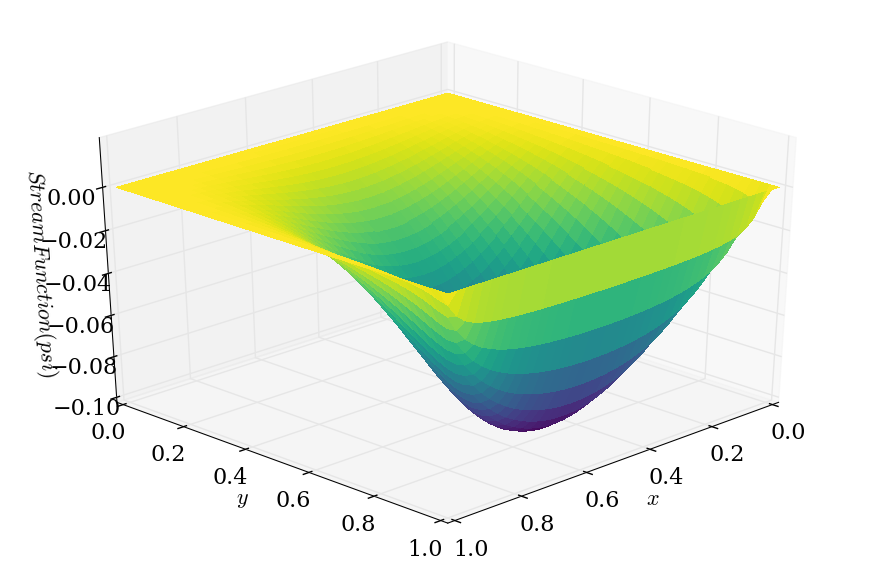

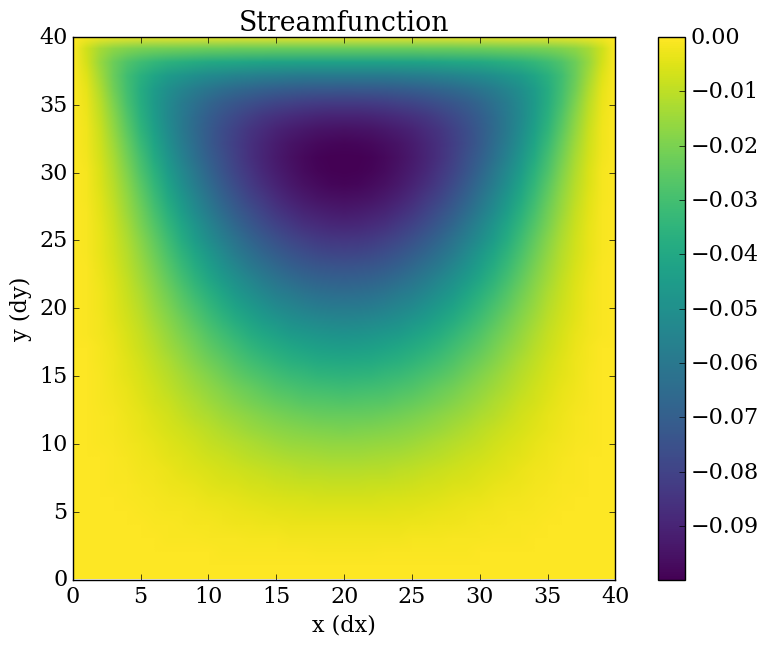

In [10]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))
w[-1,:]=-3/dy

psi, w= stokesjacobi(w.copy(),psi.copy())
plot_3D(x,y,psi)
colormap(x,y,psi)

Utilisons "jit", importé au début, pour améliorer notre implémentation de la méthode de Jacobi.
Nous allons devoir utiliser des boucles pour permettre l'utilisation de Numba.

Nous voudrons stocker les valeurs de la norme pour psi au cours des itérations successives dans le but d'examiner la convergence de nos différentes méthodes, à commencer par celle-ci.
Nous faisons donc en sorte que notre fonction crée désormais une liste contenant ces valeurs.
Elle doit contenir au moins autant d'éléments que d'itérations (car on a une norme de psi calculée par itération). Nous avons vu plus haut que le nombre d'itération pour Jacobi était de 4059. Ce nombre d'itérations devant diminuer pour les méthodes suivantes, nous partirons toujours d'une liste de 4060 éléments par la suite.

In [11]:
@jit(nopython=True)
def stokesjacobi_bis(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    normlist=numpy.zeros
    iterations=0
    normpsi_list=numpy.ones(4060)
  
    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (wn[j,i+1] + wn[j,i-1] \
                              + wn[j+1,i] + wn[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psin[j,i+1]+psin[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psin[j-1,i])*dx**2 +\
                         wn[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)

        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
       
        normpsi_list[iterations]= l1norm_psi
    
        iterations += 1 

    iter_list = numpy.linspace(1,iterations,iterations-1)

        
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,w,iter_list,normpsi_list,iterations

In [12]:
%%timeit

w=numpy.zeros((ny,nx))
psi=numpy.zeros((ny,nx))
w[-1,:]=-3/dy

psi,w,iterlist,normpsilist,iterations= stokesjacobi_bis(w.copy(),psi.copy())

4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
4059 9.997482597647045e-07 2.24232961630431e-08
The slowest run took 30.04 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 61.6 ms per loop


4059 9.997482597647045e-07 2.24232961630431e-08


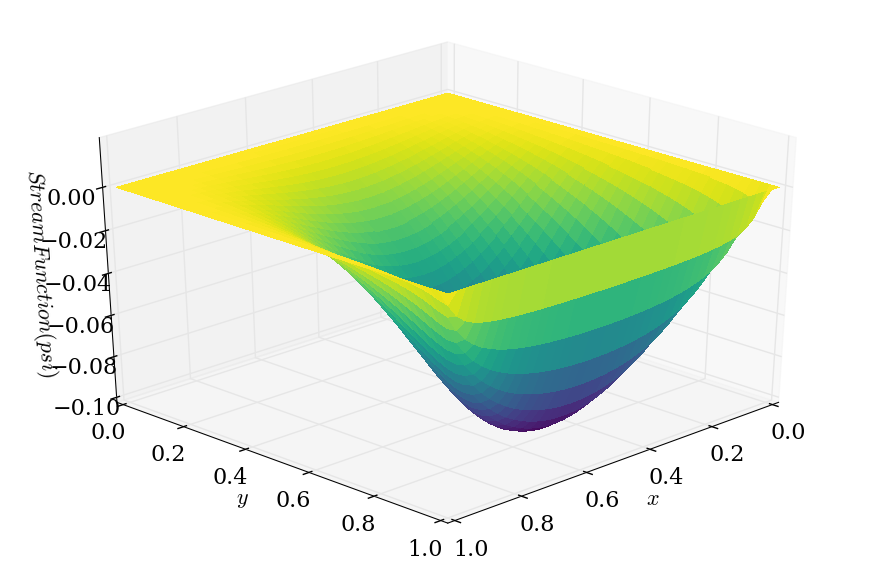

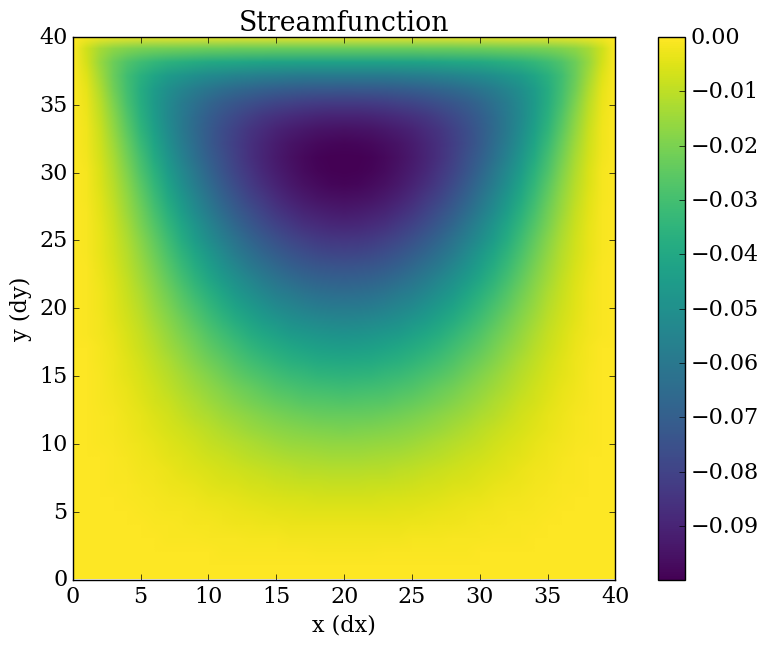

In [13]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))
w[-1,:]=-3/dy

psi, w,iterlist, normpsilist,iterations= stokesjacobi_bis(w.copy(),psi.copy())
plot_3D(x,y,psi)
colormap(x,y,psi)

On peut désormais regarder la convergence de notre méthode de Jacobi optimale en utilisant la liste des valeurs de norme l1 pour psi au cours des itérations successives.

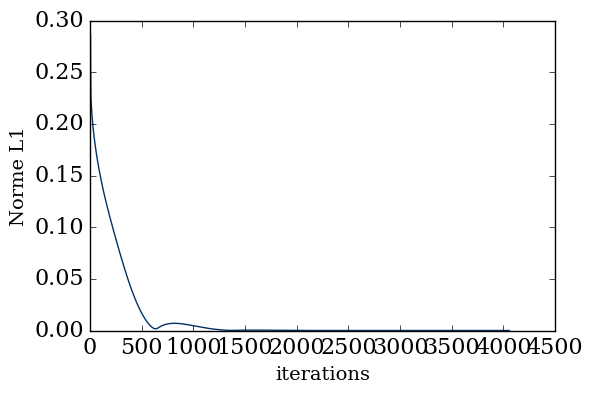

In [14]:
pyplot.plot(iterlist,normpsilist[:iterations-1], color='#003366')
pyplot.xlabel('iterations', fontsize=14)
pyplot.ylabel('Norme L1', fontsize=14)

## Vérification de notre solution:

Afin de vérifier qu'il s'agit de la bonne solution, nous allons extraire certaines valeurs de notre solution:

#### 1. Valeur maximum de $|\psi|$ à l'intérieur de la cavité:

In [15]:
round(numpy.max(numpy.abs(psi[1:-1,1:-1])),4)

0.0998

#### 2. Valeur maximum de $|\omega|$ à l'intérieur de la cavité:

*Remarque: on demande $|\omega|$ à l'intérieur de la cavité mais pour obtenir la valeur voulue dans le check il faut regarder sur cet intervalle bizarre (intérieur pour x et total pour y)*

In [16]:
round(numpy.max(numpy.abs(w[:,1:-1])),4)

78.192700000000002

#### 3. Array de psi pour y=32dy, tous les 8 valeurs de x:

In [17]:
numpy.round(psi[32,::8], 4)

array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

## 2. Méthode de Gauss-Seidel
Cette méthode est fondée sur le même principe que l'itération de Jacobi mais au lieu de toujours utiliser les valeurs de $\omega$ et de $\psi$ de l'itération précédente, on utilise le plus possible les valeurs les plus actuelles.
En effet, lorsqu'on met à jour $\psi$ et $\omega$, on le fait dans un certain ordre: on balaie le carré des valeurs (x,y) de gauche à droite (x croissants) puis ligne par ligne de haut en bas (y croissants). 
On pourra donc itérer nos valeurs comme suit:
\begin{equation}
\omega^{k+1}_{i,j} = \frac{1}{4} \left(\omega^{k+1}_{i,j-1} + \omega^k_{i,j+1} + \omega^{k+1}_{i-1,j} + \omega^k_{i+1,j} \right)
\end{equation}
(valable seulement pour $\Delta x= \Delta y$)
\begin{equation}
\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k+1})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k+1})\Delta x^2+\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}
\end{equation}


Ceci devrait permettre de diminuer le nombre d'itérations nécessaires pour arriver à la solution. Cependant, on ne peut plus utiliser le calcul par les listes et on doit retourner aux boucles "for". Pour éviter que cela ne prenne trop de temps de calcul, on utilise "numba" et "jit", qui vont en fait compiler notre code et l'optimiser. 

In [18]:

@jit(nopython=True)
def stokesGauss(w,psi):
    '''Iteratively solves the Stokes flow equation using the Jacobi method
    
    Parameters:
    ----------
    w: 2D array of float
        Initial vorticity 
    psi: 2D array of floats
        Initial streamfunction
    Returns:
    -------
    w: Vorticity after relaxation
    psi: Streamfunction after relaxation
    '''
    
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    normpsi_list=numpy.ones(4060)
    
    
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = .25 * (w[j,i+1] + w[j,i-1] \
                              + w[j+1,i] + w[j-1,i])
        
       
                psi[j,i] = 1/(2*(dx**2 + dy**2)) * \
                        ((psi[j,i+1]+psi[j,i-1])*dy**2 +\
                        (psi[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
            
        ##B.C on the top of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)

        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
        normpsi_list[iterations]= l1norm_psi
        
    
        iterations += 1 
        
    iter_list = numpy.linspace(1,iterations,iterations-1)
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,iter_list,normpsi_list,iterations

In [19]:
%%timeit
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi2=numpy.zeros((nx,ny))
w[-1,:]=-3/dy
psi2,iterlist,normpsilist,iterations= stokesGauss(w.copy(),psi2.copy())

2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
2120 9.944902060721704e-07 8.704372861761549e-09
The slowest run took 29.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 47.8 ms per loop


In [20]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi2=numpy.zeros((nx,ny))
w[-1,:]=-3/dy
psi2,iterlist,normpsilist,iterations= stokesGauss(w.copy(),psi2.copy())


2120 9.944902060721704e-07 8.704372861761549e-09


array([ 0.    , -0.0575, -0.0944, -0.0944, -0.0575,  0.    ])

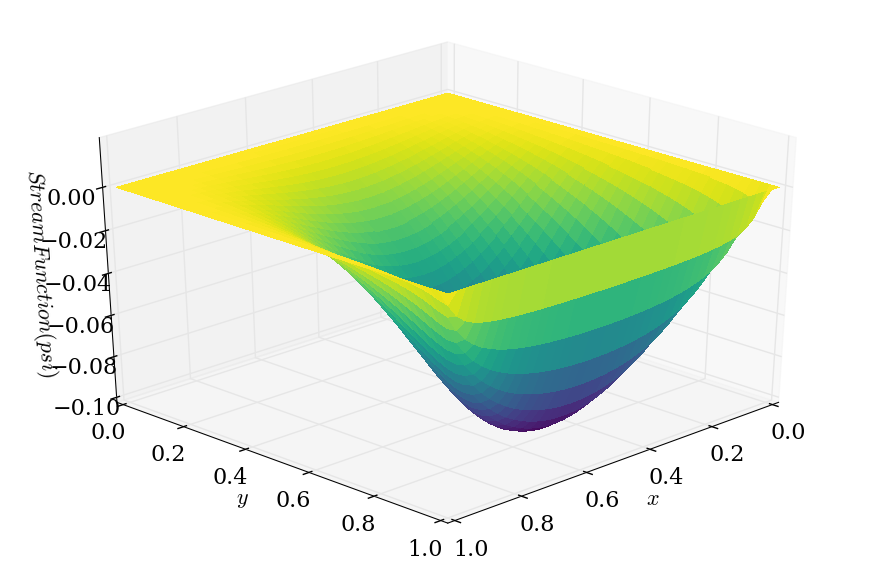

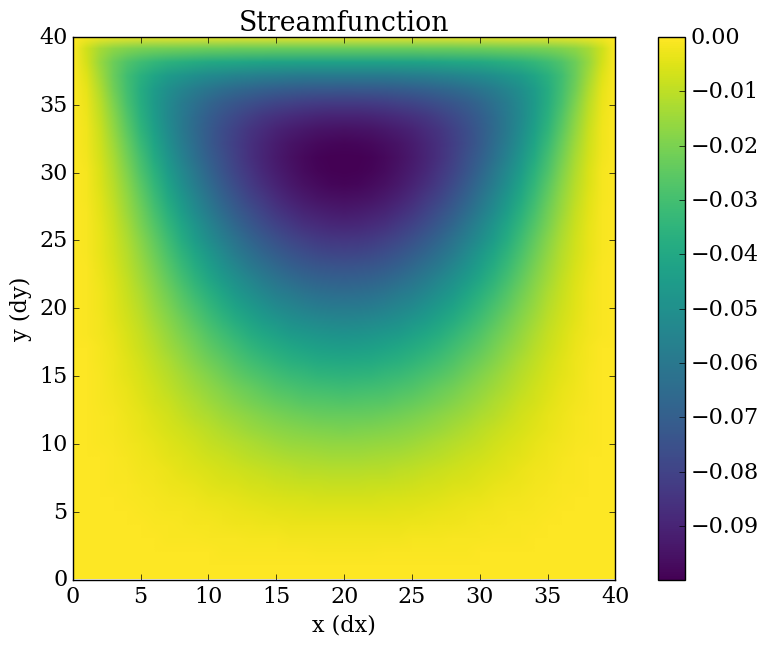

In [21]:
plot_3D(x,y,psi2)
colormap(x,y,psi2)
numpy.round(psi2[32,::8], 4)

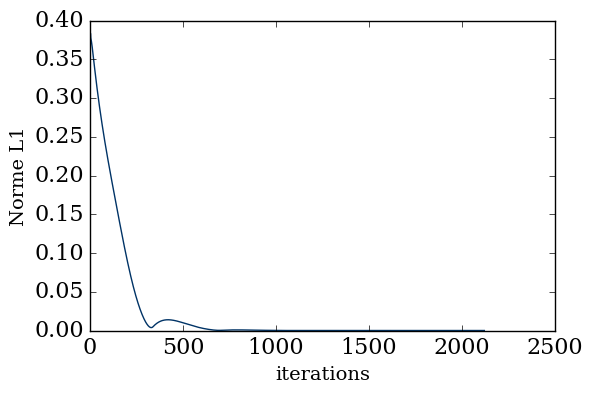

In [22]:
pyplot.plot(iterlist,normpsilist[:iterations-1], color='#003366')
pyplot.xlabel('iterations', fontsize=14)
pyplot.ylabel('Norme L1', fontsize=14)

## 3. Méthode SOR 

In [23]:
@jit(nopython=True)
def stokesSOR(w,psi,omega):
   
    l1norm_w = 1
    l1norm_psi=1
    wn = numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    iterations=0
    normpsi_list=numpy.ones(4060)
    
    while (l1norm_psi>l1_target or l1norm_w>l1_target):
        l1norm_w=0
        l1norm_psi=0
        
        for j in range(ny):
            for i in range(nx):
                wn[j,i] = w[j,i]
                psin[j,i] = psi[j,i]
                
    
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                w[j,i] = (1-omega)*wn[j,i] + omega*.25 * (wn[j,i+1] + w[j,i-1] + wn[j+1,i] + w[j-1,i])
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                psi[j,i] = (1-omega)*psi[j,i]+ (omega/(2*(dx**2 + dy**2))) * \
                        ((psin[j,i+1]+psi[j,i-1])*dy**2 +\
                        (psin[j+1,i] + psi[j-1,i])*dx**2 +\
                         w[j,i]*dx**2*dy**2)
            
        ##B.C on the edge of the square
        for i in range(nx):
            w[-1,i]=(-1/(dy)**2)*(4*psi[-2,i]-psi[-3,i]/2)-3.0/dy
            w[0,i]=(-1/(dy)**2)*(4*psi[1,i]-psi[2,i]/2)  
        for j in range(ny):
            w[j,-1]=(-1/(dx)**2)*(4*psi[j,-2]-psi[j,-3]/2)
            w[j,0]=(-1/(dx)**2)*(4*psi[j,1]-psi[j,2]/2)
           
        for j in range(ny):
            for i in range(nx):
                l1norm_w += numpy.abs(w[j,i] - wn[j,i])
                
                l1norm_psi += numpy.abs(psi[j,i] - psin[j,i])
                
        normpsi_list[iterations]= l1norm_psi
        
    
        iterations += 1 
        
    iter_list = numpy.linspace(1,iterations,iterations-1)
        
    print(iterations,l1norm_w,l1norm_psi)
    return psi,w,iter_list,normpsi_list,iterations

In [24]:
%%timeit
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi3=numpy.zeros((nx,ny))
w[-1,:]=-3/dy
psi3,w,iterlist,normpsilist,iterations= stokesSOR(w.copy(),psi3.copy(),1.18)

1505 9.992319196470154e-07 3.486603222564561e-09
1505 9.992319196470154e-07 3.486603222564561e-09
1505 9.992319196470154e-07 3.486603222564561e-09
1505 9.992319196470154e-07 3.486603222564561e-09
The slowest run took 24.05 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 60.8 ms per loop


1467 9.914589030190915e-07 2.7735791983938208e-08


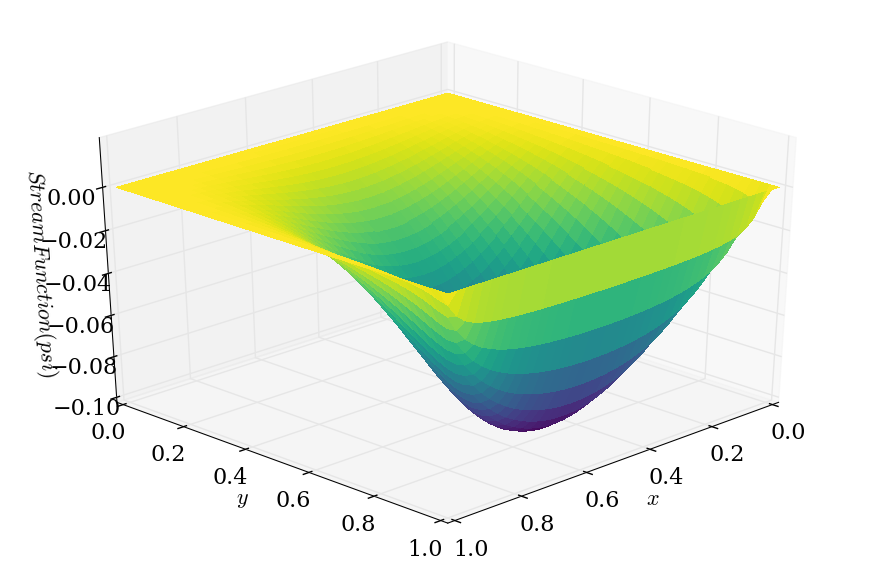

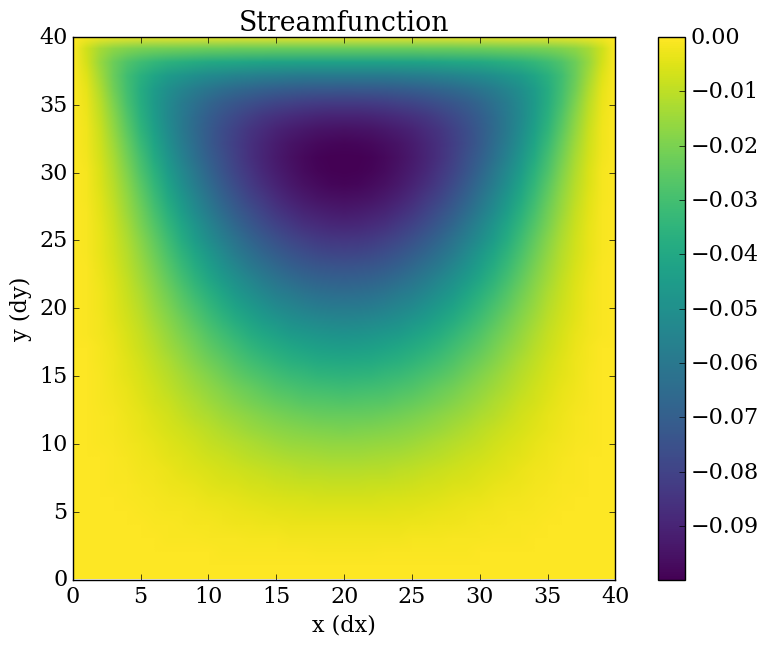

In [25]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi3=numpy.zeros((nx,ny))
w[:,-1]=-3/dy
psi3,w,iterlist,normpsilist,iterations= stokesSOR(w.copy(),psi.copy(),1.18)
plot_3D(x,y,psi3)
numpy.round(psi3[32,::8], 4)
colormap(x,y,psi3)

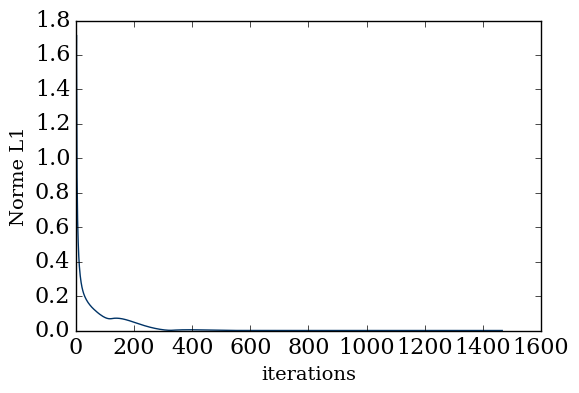

In [26]:
pyplot.plot(iterlist,normpsilist[:iterations-1], color='#003366')
pyplot.xlabel('iterations', fontsize=14)
pyplot.ylabel('Norme L1', fontsize=14)

## 4. Steepest Descent

On considère l'équation comme une équation de matrice Ax=b.
Dans notre cas, on aura deux systèmes d'équations couplés:
$$A\omega=0$$
$$A\psi=-\omega$$
où $$A=\nabla^{2}$$
En discrétisant cet opérateur, on obtient que 

$$\nabla^{2}p=\frac{p_{i+1,j}^{k}-2p_{i,j}^{k}+p_{i-1,j}^{k}}{\Delta x^2}+\frac{p_{i,j+1}^{k}-2 p_{i,j}^{k}+p_{i,j-1}^{k}}{\Delta y^2}$$
Pour n'importe quelle fonction p.

In [27]:
def steep_des(w,psi):
    
    
    l1norm_w = 1
    l1norm_psi=1
    wn= numpy.empty_like(w)
    psin=numpy.empty_like(psi)
    Aresi_w=numpy.empty_like(psi)
    Aresi_psi= numpy.empty_like(psi)
    residual_w=numpy.empty_like(w)
    residual_psi=numpy.empty_like(psi)
    iterations=0
    

    while (l1norm_w>l1_target or l1norm_psi>l1_target) :
        l1norm_w = 0
        l1norm_psi= 0
        
        wn = w.copy()
        psin=psi.copy()
        
            
        residual_w[1:-1,1:-1]= (4*wn[1:-1,1:-1] - wn[1:-1,2:] - wn[1:-1,:-2] - wn[2:, 1:-1] - wn[:-2, 1:-1])/dx**2
        
        Aresi_w[1:-1,1:-1] = (-4*residual_w[1:-1,1:-1] + \
                         residual_w[1:-1,2:] + residual_w[1:-1,:-2] + residual_w[2:, 1:-1] + residual_w[:-2, 1:-1])/dx**2
        
        numw = numpy.sum(residual_w[1:-1,1:-1]*residual_w[1:-1,1:-1])
        denw = numpy.sum(residual_w[1:-1,1:-1]*Aresi_w[1:-1,1:-1])
        alphaw = numw/denw
        w[1:-1,1:-1] = wn[1:-1,1:-1] + alphaw*residual_w[1:-1,1:-1]
        

        
        residual_psi[1:-1,1:-1] = -w[1:-1,1:-1]+(4*psin[1:-1,1:-1]\
                                -(psin[1:-1,2:]+psin[1:-1,:-2] +\
                                psin[2:,1:-1] + psin[:-2,1:-1]))/dx**2
        
                                                  
        Aresi_psi[1:-1,1:-1] = (-4*residual_psi[1:-1,1:-1] + residual_psi[1:-1,2:] + residual_psi[1:-1,:-2] +\
                                residual_psi[2:,1:-1] + residual_psi[:-2,1:-1])/dx**2
        

        numpsi = numpy.sum(residual_psi[1:-1,1:-1]*residual_psi[1:-1,1:-1])
        denpsi = numpy.sum(residual_psi[1:-1,1:-1]*Aresi_psi[1:-1,1:-1])
        alphapsi = numpsi/denpsi
            
       
        psi[1:-1,1:-1] = psin[1:-1,1:-1] + alphapsi*residual_psi[1:-1,1:-1]
        
        ##B.C on the edge of the square
        w[-1,:]=(-1/(dx)**2)*(4*psi[-2,:]-psi[-3,:]/2)-3.0/dy
        w[0,:]=(-1/(dx)**2)*(4*psi[1,:]-psi[2,:]/2) 
        w[:,-1]=(-1/(dy)**2)*(4*psi[:,-2]-psi[:,-3]/2)
        w[:,0]=(-1/(dy)**2)*(4*psi[:,1]-psi[:,2]/2)
 
        l1norm_w=L1norm(w,wn)
        l1norm_psi=L1norm(psi,psin)
        
    
        iterations += 1 
        
        
        
    print(l1norm_w,l1norm_psi)
    return psi

nan nan


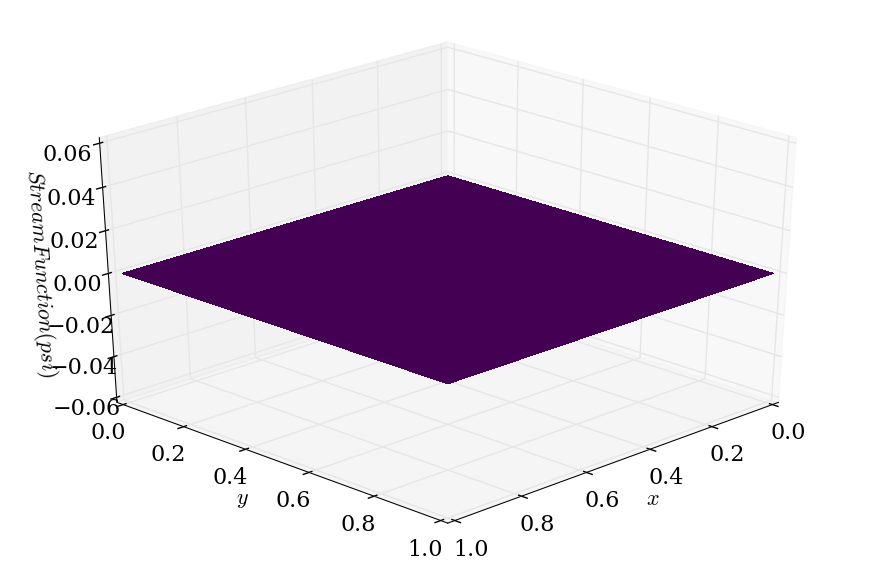

C:\Users\Frédérick\Anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


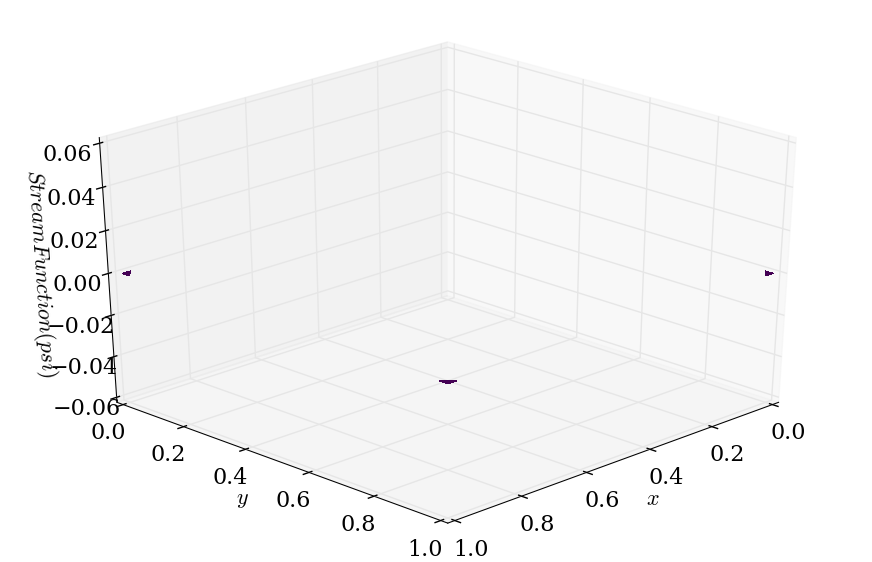

In [28]:
x = numpy.linspace(0,1,nx)
y = numpy.linspace(0,1,ny)

w=numpy.zeros((nx,ny))
psi4=numpy.zeros((nx,ny))
w[-1,:]=-3/dy
plot_3D(x,y,psi4)

psi4= steep_des(w.copy(),psi4.copy())
plot_3D(x,y,psi4)

Cette méthode ne semble pas converger. Ceci est dû au fait que la matrice A doit être symétrique pour que cette méthode donne effectivement la solution de l'équation $Ax=b$. Dans le cas contraire, elle nous donne la solution de l'équation:
$\frac{1}{2}(A+A^{T})x=b$

Autre raison possible: si A n'est pas définie positive, alors les méthodes de steepest descent et du conjugate gradient ne fonctionnent pas du tout.